In [102]:
import numpy as np
import math
from numba import jit
import vegas
from mpi4py import MPI
import time  # 导入 time 模块
import sys
from scipy.integrate import quad

# 获取当前时间，生成带时间戳的文件名
current_time = time.strftime("%m%d_%H%M%S")
output_file = f"res_{current_time}.txt" 


# 在主程序开始时记录时间
start_time = time.time()


me=0.511
e=0.303
Z=29
l=10
fact_l=math.factorial(abs(l))
# 这里sigma是坐标空间的
sigma_perp=1000
sigma_z=500     # 0.1nm左右
P_z=5
b_perp0=3000
C_in1=-Z*e**3*np.pi/(2*np.pi)**(3)*(4*np.pi)**(3/4)*np.sqrt(sigma_z/fact_l)*sigma_perp*(sigma_perp)**(abs(l))
C_in2=-Z*e**3*np.pi/(2*np.pi)**(3)*(4*np.pi)**(3/4)*np.sqrt(2**l*sigma_z/fact_l)*sigma_perp/32   # no_ilphi_r 情况，且仅针对l=10

C_out=1/256/np.pi**6

# 定义 2x2 单位矩阵和泡利矩阵
I_2 = np.eye(2, dtype=np.complex128)
I_4 = np.eye(4, dtype=np.complex128)
sigma1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sigma3 = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# 定义 Gamma 矩阵
gamma0 = np.block([[I_2, np.zeros((2, 2))], [np.zeros((2, 2)), -I_2]])
gamma1 = np.block([[np.zeros((2, 2)), sigma1], [-sigma1, np.zeros((2, 2))]])
gamma2 = np.block([[np.zeros((2, 2)), sigma2], [-sigma2, np.zeros((2, 2))]])
gamma3 = np.block([[np.zeros((2, 2)), sigma3], [-sigma3, np.zeros((2, 2))]])



@jit(nopython=True)
def photon_polar_conj(lamb,theta_k,phi_k):
    res=np.array([0,
                     1/np.sqrt(2)*(-lamb*np.cos(theta_k)*np.cos(phi_k)-1j*np.sin(phi_k)),
                     1/np.sqrt(2)*(-lamb*np.cos(theta_k)*np.sin(phi_k)+1j*np.cos(phi_k)),
                     lamb/np.sqrt(2)*np.sin(theta_k)], dtype=np.complex128)
    return res



@jit(nopython=True)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

# @jit(nopython=True)
# def two_vec_mod(energy,m,theta,phi):
#     p=np.sqrt(energy**2-m**2)
#     two_vec=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)])
#     res=np.sqrt(two_vec@two_vec)
#     return res

@jit(nopython=True)
def four_vec_slash(energy,m,theta,phi):
    four_vec_=four_vec(energy,m,theta,phi)
    res= four_vec_[0]*gamma0
    res +=-four_vec_[1]*gamma1
    res +=-four_vec_[2]*gamma2
    res +=-four_vec_[3]*gamma3
    return res

@jit(nopython=True)
def photon_polar_slash(lamb,theta_k,phi_k):
    photon_polar_=photon_polar_conj(lamb,theta_k,phi_k)
    res= photon_polar_[0]*gamma0
    res +=-photon_polar_[1]*gamma1
    res +=-photon_polar_[2]*gamma2
    res +=-photon_polar_[3]*gamma3
    return res
    
@jit(nopython=True)
def u(energy,theta,phi,spin):
    fvp=four_vec(energy,me,theta,phi)
    if spin > 0:
        part1=np.sqrt(fvp[0]+me)
        part2=0
        part3=fvp[3]/np.sqrt(fvp[0]+me)
        part4=(fvp[1]+1j*fvp[2])/np.sqrt(fvp[0]+me)  
    if spin < 0:
        part1=0
        part2=np.sqrt(fvp[0]+me)
        part3=(fvp[1]-1j*fvp[2])/np.sqrt(fvp[0]+me)
        part4=(-fvp[3])/np.sqrt(fvp[0]+me)
    res=np.array([part1,part2,part3,part4],dtype=np.complex128)
    return res

@jit(nopython=True)
def u_f(energy,theta,phi,spin):
    fvp=four_vec(energy,me,theta,phi)
    if spin > 0:
        part1=np.sqrt(fvp[0]+me)
        part2=0
        part3=-fvp[3]/np.sqrt(fvp[0]+me)
        part4=-(fvp[1]-1j*fvp[2])/np.sqrt(fvp[0]+me)  
    if spin < 0:
        part1=0
        part2=np.sqrt(fvp[0]+me)
        part3=-(fvp[1]+1j*fvp[2])/np.sqrt(fvp[0]+me)
        part4=(fvp[3])/np.sqrt(fvp[0]+me)
    res=np.array([part1,part2,part3,part4],dtype=np.complex128)
    return res

@jit(nopython=True)
def Phi_cap1(epsilon, theta, phi, l):
    p=np.sqrt(epsilon**2-me**2)
    two_vec_mod_=p*np.sin(theta)
    res= np.sqrt(2*epsilon)*(two_vec_mod_)**(abs(l))\
       *np.exp(-sigma_perp**2*two_vec_mod_**2/2-sigma_z**2*(p*np.cos(theta)-P_z)**2/2+1j*l*phi)
    return C_in1*res


## no_ilphi_r
@jit(nopython=True)
def Phi_cap2(epsilon, theta, phi, l):
    p=np.sqrt(epsilon**2-me**2)
    sigma_vec_mod_sq=p**2*np.sin(theta)**2*sigma_perp**2
    res= np.sqrt(2*epsilon)*(3840-9600*sigma_vec_mod_sq+4800*sigma_vec_mod_sq**2-800*sigma_vec_mod_sq**3+50*sigma_vec_mod_sq**4-sigma_vec_mod_sq**5)\
       *np.exp(-sigma_vec_mod_sq/2-sigma_z**2*(p*np.cos(theta)-P_z)**2/2)
    return C_in2*res

@jit(nopython=True)
def curl_L_pre(no,theta_,phi_,s,omega,epsilon_f,three_vec_f,three_vec_k,u_f_,photon_polar_slash_,four_vec_slash_k,four_vec_slash_f,b_perp):
    epsilon=epsilon_f+omega
    p_mod=np.sqrt(epsilon**2-me**2)
    three_vec_i=three_vec(epsilon,me,theta_,phi_)
    M_res=1/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                        u_f_@\
                        (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                        (four_vec_slash_f+four_vec_slash_k+me*I_4)@gamma0\
                        +\
                        1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                        (four_vec_slash(epsilon,me,theta_,phi_)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                        u(epsilon,theta_,phi_,s)
    if no==1:
        res=p_mod*np.sin(theta_)*Phi_cap1(epsilon,theta_,phi_,l)*np.exp(-1j*b_perp*p_mod*np.sin(theta_)*np.cos(phi_))*M_res
    elif no==2:
        res=p_mod*np.sin(theta_)*Phi_cap2(epsilon,theta_,phi_,l)*np.exp(-1j*b_perp*p_mod*np.sin(theta_)*np.cos(phi_))*M_res
    return res







In [111]:
# def curl_L(no,s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb,b_perp, N_theta=80, N_phi=500):
#     """ 使用梯形法计算复数二重积分 """
#     # 其他参数不变的情况下，l=100取(0.0015, 0.0026)(40,2000),l=10取(0, 0.0015）(80,300),l=0取(0,0.0008)(100,300)
#     theta_vals = np.linspace(0, 0.0015, N_theta)  # θ 从 0 到 π  这个积分范围要随着sigma与l的变化而变化
#     phi_vals   = np.linspace(0, 2*np.pi, N_phi)  # φ 从 0 到 2π
#     # 计算函数值的网格存放
#     F_vals = np.zeros((N_theta, N_phi), dtype=np.complex128)  # 复数数组

    
#     three_vec_f_for=three_vec(epsilon_f,me,theta_f,phi_f)
#     three_vec_k_for=three_vec(omega,0,theta_k,phi_k)
#     u_f_for=u_f(epsilon_f,theta_f,phi_f,s_f)
#     photon_polar_slash_for=photon_polar_slash(lamb,theta_k,phi_k)
#     four_vec_slash_k_for=four_vec_slash(omega,0,theta_k,phi_k) 
#     four_vec_slash_f_for=four_vec_slash(epsilon_f,me,theta_f,phi_f)

#     # 遍历网格, 计算 curl_L_pre
#     for i, theta_for in enumerate(theta_vals):
#         for j, phi_for in enumerate(phi_vals):
#             F_vals[i, j] = curl_L_pre(no,theta_for,phi_for,s,omega,epsilon_f,three_vec_f_for,three_vec_k_for,u_f_for,photon_polar_slash_for,four_vec_slash_k_for,four_vec_slash_f_for,b_perp)
#     # **第一步: 先对 phi 方向进行梯形法积分**
#     int_phi = np.trapz(F_vals, phi_vals, axis=1)  # 对每个 theta 积分
#     # **第二步: 再对 theta 方向进行梯形法积分**
#     integral = np.trapz(int_phi, theta_vals)
    
#     return integral



def curl_L(no,s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb,b_perp):
    """ 使用 quad 计算复数二重积分 """
    # 定义 theta 和 phi 的积分范围
     # 其他参数不变的情况下，l=100取0.0015, 0.0026,l=10取0, 0.0015,l=0取0,0.0008
    theta_min, theta_max = 0, 0.0015 # θ 的积分范围
    phi_min, phi_max = 0, 2 * np.pi   # φ 的积分范围

    # 预计算一些常量
    three_vec_f_for = three_vec(epsilon_f, me, theta_f, phi_f)
    three_vec_k_for = three_vec(omega, 0, theta_k, phi_k)
    u_f_for = u_f(epsilon_f, theta_f, phi_f, s_f)
    photon_polar_slash_for = photon_polar_slash(lamb, theta_k, phi_k)
    four_vec_slash_k_for = four_vec_slash(omega, 0, theta_k, phi_k)
    four_vec_slash_f_for = four_vec_slash(epsilon_f, me, theta_f, phi_f)

    # 定义被积函数（对 theta 积分）
    def integrand_theta_real(phi_for):
        """ 对 theta 积分的实部 """
        def integrand(theta_for):
            val = curl_L_pre(no,theta_for, phi_for, s, omega, epsilon_f, three_vec_f_for, three_vec_k_for, u_f_for, photon_polar_slash_for, four_vec_slash_k_for, four_vec_slash_f_for,b_perp)
            return val.real
        result, _ = quad(integrand, theta_min, theta_max)
        return result

    def integrand_theta_imag(phi_for):
        """ 对 theta 积分的虚部 """
        def integrand(theta_for):
            val = curl_L_pre(no,theta_for, phi_for, s, omega, epsilon_f, three_vec_f_for, three_vec_k_for, u_f_for, photon_polar_slash_for, four_vec_slash_k_for, four_vec_slash_f_for,b_perp)
            return val.imag
        result, _ = quad(integrand, theta_min, theta_max)
        return result

    # 对 phi 进行积分
    integral_real, error_r = quad(integrand_theta_real, phi_min, phi_max)
    integral_imag, error_i = quad(integrand_theta_imag, phi_min, phi_max)

    # 合并结果
    integral = integral_real + 1j * integral_imag
    return integral 


print(curl_L(1,0.5,3.026,np.pi/2,np.pi/3,0.5,2,np.pi/3,np.pi/3,1,3100))

(0.0006014809234917185-1.4990804037156072e-07j)


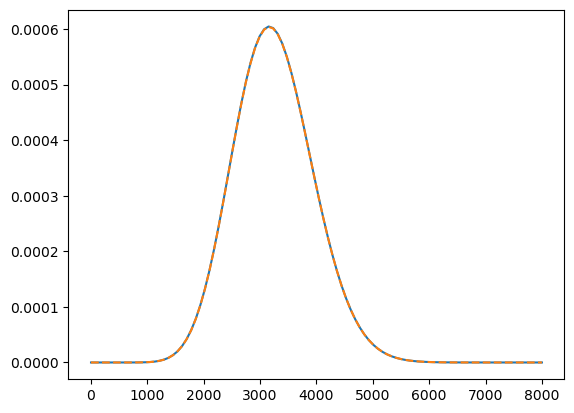

In [100]:
b_values = np.linspace(0,8000, 100)
curl_L_mods=[]
for b_for in b_values:
    curl_L_mods.append(abs(curl_L(1,0.5,3.026,np.pi/2,np.pi/3,0.5,2,np.pi/3,np.pi/3,1,b_for)))
# no ilphi_r
curl_L_mods_no=[]
for b_for in b_values:
    curl_L_mods_no.append(abs(curl_L(2,0.5,3.026,np.pi/2,np.pi/3,0.5,2,np.pi/3,np.pi/3,1,b_for)))

# 3. 绘制图表
fig,ax=plt.subplots()
ax.plot(b_values,curl_L_mods_no)
ax.plot(b_values,curl_L_mods,'--')